In [57]:
#Basic libraries
import pandas as pd 
import numpy as np 

#NLTK libraries
import nltk
import re
import string
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

#Visulization Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Part of Speech parsing/processing library
import spacy
spacy.cli.download("en_core_web_sm")
from scipy.stats import norm

#library for sentiment analysis
from textblob import TextBlob
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#ML Library
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report,ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\foram\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
#Read file
df=pd.read_csv("C:\\Users\\foram\\Desktop\\MMA\\ML-model\\Amazon_Reviews_Sentiment_Analysis\\Amazon_Reviews.csv", sep=",")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewerID      10261 non-null  object
 1   asin            10261 non-null  object
 2   reviewerName    10234 non-null  object
 3   helpful/0       10261 non-null  int64 
 4   helpful/1       10261 non-null  int64 
 5   reviewText      10254 non-null  object
 6   overall         10261 non-null  int64 
 7   summary         10261 non-null  object
 8   unixReviewTime  10261 non-null  int64 
 9   reviewTime      10261 non-null  object
dtypes: int64(4), object(6)
memory usage: 801.8+ KB


In [7]:
df.shape

(10261, 10)

In [8]:
df.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName  helpful/0  helpful/1  \
0  cassandra tu "Yeah, well, that's just like, u...          0          0   
1                                              Jake         13         14   
2                     Rick Bennette "Rick Bennette"          1          1   
3                         RustyBill "Sunday Rocker"          0          0   
4                                     SEAN MASLANKA          0          0   

                                          reviewText  overall  \
0  Not much to write about here, but it does exac...        5   
1  The product does exactly as it should and is q...        5   
2  The primary job of this device is to block the...        5   
3  Nice windscreen protects my MXL mic and preven...        5   
4  This pop filter is great. It looks and perform...        5   

                                 summary  unixReviewTime   reviewTime  
0                                   good      1393545600  02 28, 2014  
1                                   Jake      1363392000  03 16, 2013  
2                   It Does The Job Well      1377648000  08 28, 2013  
3          GOOD WINDSCREEN FOR THE MONEY      1392336000  02 14, 2014  
4  No more pops when I record my vocals.      1392940800  02 21, 2014

In [9]:
#Creating a copy
process_reviews=df.copy()

#Checking for null values
process_reviews.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful/0          0
helpful/1          0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

In [10]:
#fill missing values with missing
process_reviews['reviewText']=process_reviews['reviewText'].fillna('Missing')

In [11]:
#Concatenating review text and summary
process_reviews['reviews']=process_reviews['reviewText']+process_reviews['summary']
process_reviews=process_reviews.drop(['reviewText', 'summary'], axis=1)
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName  helpful/0  helpful/1  \
0  cassandra tu "Yeah, well, that's just like, u...          0          0   
1                                              Jake         13         14   
2                     Rick Bennette "Rick Bennette"          1          1   
3                         RustyBill "Sunday Rocker"          0          0   
4                                     SEAN MASLANKA          0          0   

   overall  unixReviewTime   reviewTime  \
0        5      1393545600  02 28, 2014   
1        5      1363392000  03 16, 2013   
2        5      1377648000  08 28, 2013   
3        5      1392336000  02 14, 2014   
4        5      1392940800  02 21, 2014   

                                             reviews  
0  Not much to write about here, but it does exac...  
1  The product does exactly as it should and is q...  
2  The primary job of this device is to block the...  
3  Nice windscreen protects my MXL mic and preven...  
4  This pop filter is great. It looks and perform...

In [12]:
#Keeping only important columns for sentiment anlysis and removing other columns
process_reviews.drop(['reviewerID','asin','reviewerName','unixReviewTime','reviewTime','helpful/0','helpful/1'],axis=1,inplace=True)
process_reviews.head()

overall                                            reviews
0        5  Not much to write about here, but it does exac...
1        5  The product does exactly as it should and is q...
2        5  The primary job of this device is to block the...
3        5  Nice windscreen protects my MXL mic and preven...
4        5  This pop filter is great. It looks and perform...

In [13]:
#Figuring out the distribution of categories
process_reviews['overall'].value_counts()

5    6938
4    2084
3     772
2     250
1     217
Name: overall, dtype: int64

Text(0.5, 1.0, 'Count of Reviews')

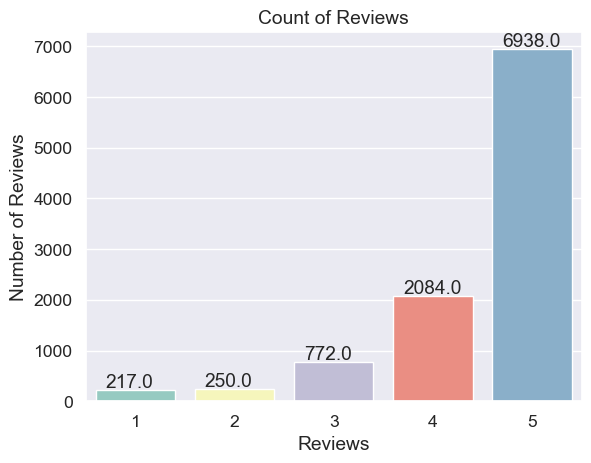

In [14]:
sns.set_theme(style='darkgrid',font_scale=1.15,palette="Set3")
ax=sns.countplot(x='overall',data=process_reviews)
for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.xlabel('Reviews')
plt.ylabel('Number of Reviews')
plt.title('Count of Reviews')

In [15]:
def sentiment_fn(row):
    
    '''This function returns sentiment value based on the overall ratings from the user'''
    
    if row['overall'] == 3.0:
        val = 'Neutral'
    elif row['overall'] == 1.0 or row['overall'] == 2.0:
        val = 'Negative'
    elif row['overall'] == 4.0 or row['overall'] == 5.0:
        val = 'Positive'
    else:
        val = -1
    return val

In [16]:
#Applying the function in our new column
process_reviews['sentiment'] = process_reviews.apply(sentiment_fn, axis=1)
process_reviews.head()

overall                                            reviews sentiment
0        5  Not much to write about here, but it does exac...  Positive
1        5  The product does exactly as it should and is q...  Positive
2        5  The primary job of this device is to block the...  Positive
3        5  Nice windscreen protects my MXL mic and preven...  Positive
4        5  This pop filter is great. It looks and perform...  Positive

In [17]:
process_reviews['sentiment'].value_counts()

Positive    9022
Neutral      772
Negative     467
Name: sentiment, dtype: int64

In [18]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [19]:
process_reviews['reviews']=process_reviews['reviews'].apply(lambda x:review_cleaning(x))
process_reviews.head()

overall                                            reviews sentiment
0        5  not much to write about here but it does exact...  Positive
1        5  the product does exactly as it should and is q...  Positive
2        5  the primary job of this device is to block the...  Positive
3        5  nice windscreen protects my mxl mic and preven...  Positive
4        5  this pop filter is great it looks and performs...  Positive

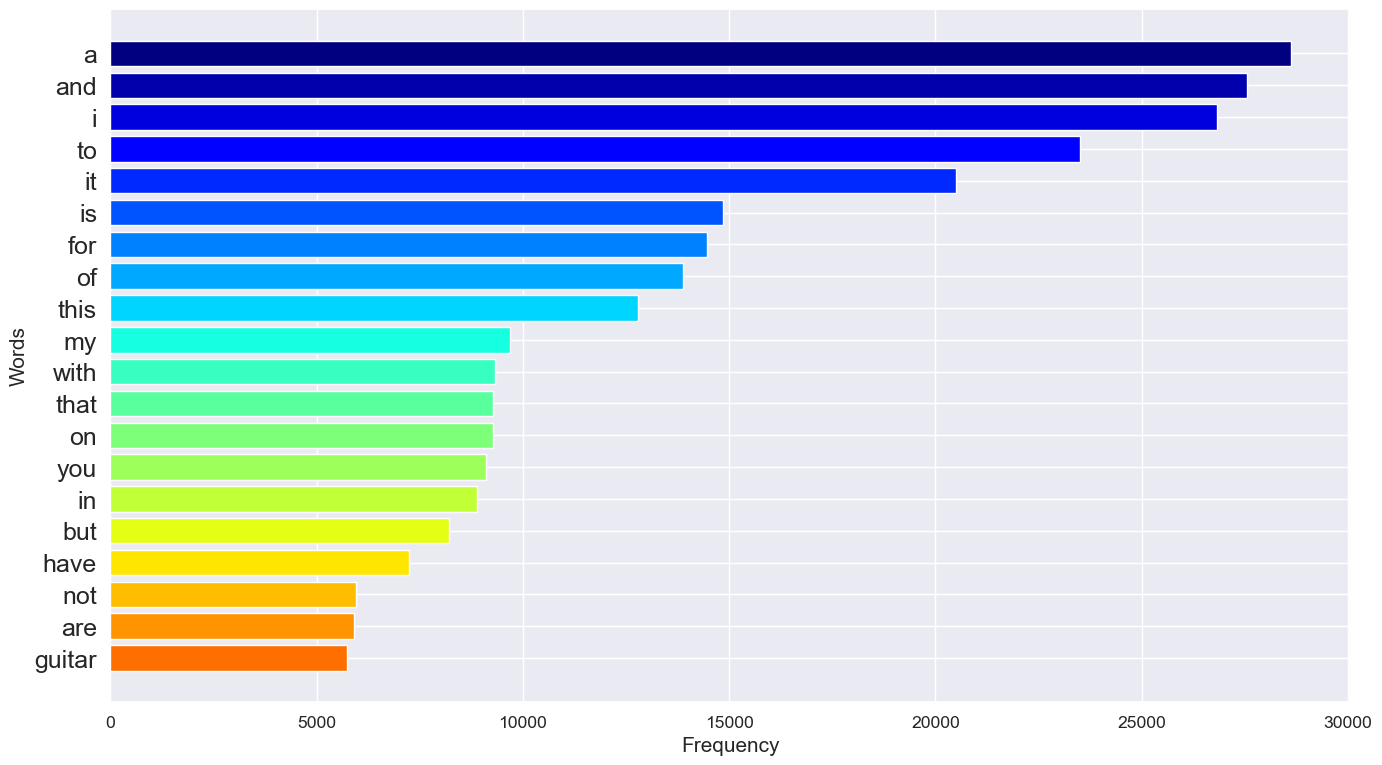

In [20]:
from collections import Counter

words = [x.split() for x in process_reviews.reviews.values]
from itertools import chain
cx = Counter(list(chain(*words)))
top = 20
most_common = cx.most_common()[1:]
x, y = zip(*most_common[:top])
fig, ax = plt.subplots(1, figsize=(16,9))
ax.barh(range(len(x)), y, color = plt.cm.jet(np.linspace(0, 1, 25)))
ax.invert_yaxis()
ax.set_xlabel('Frequency', fontsize=15)
ax.set_ylabel('Words' , fontsize=15)
ax.set_yticks(np.arange(len(x)))
ax.set_yticklabels(x, fontsize=18)
plt.show()

In [21]:
review_pos = process_reviews[process_reviews["sentiment"]=='Positive'].dropna()
review_neu = process_reviews[process_reviews["sentiment"]=='Neutral'].dropna()
review_neg = process_reviews[process_reviews["sentiment"]=='Negative'].dropna()

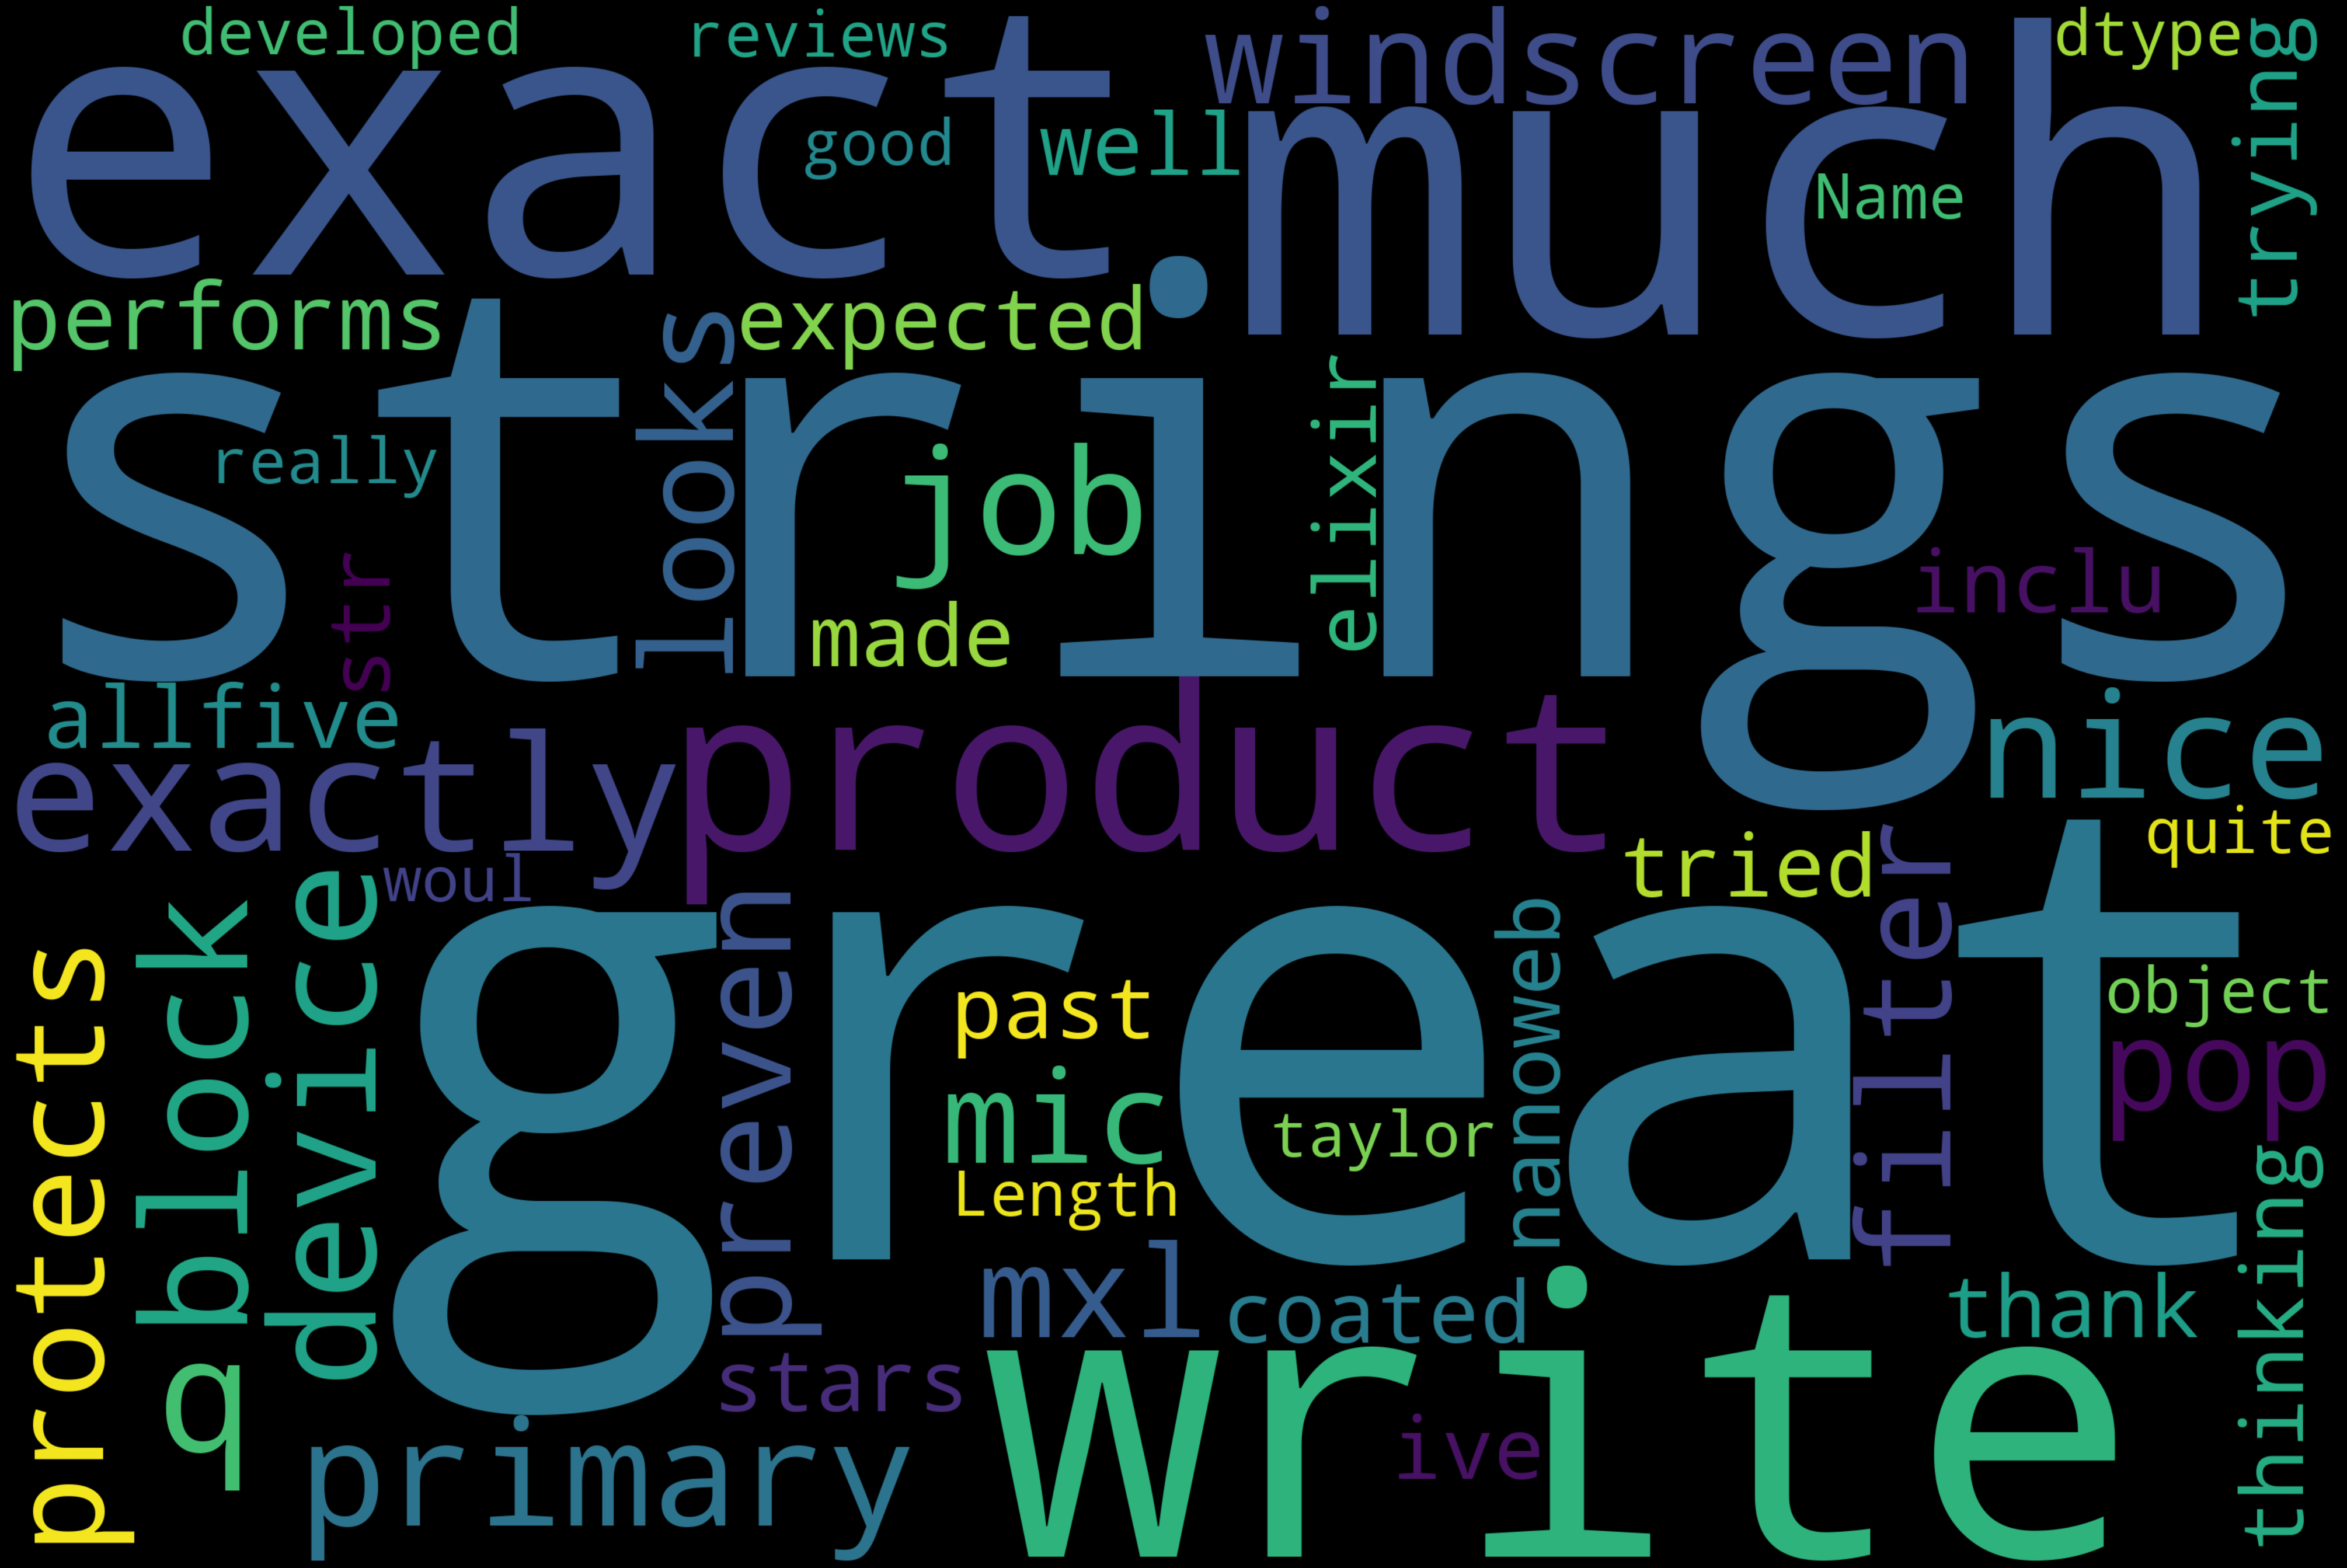

In [22]:
#word cloud of positive reviews
text = review_pos["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

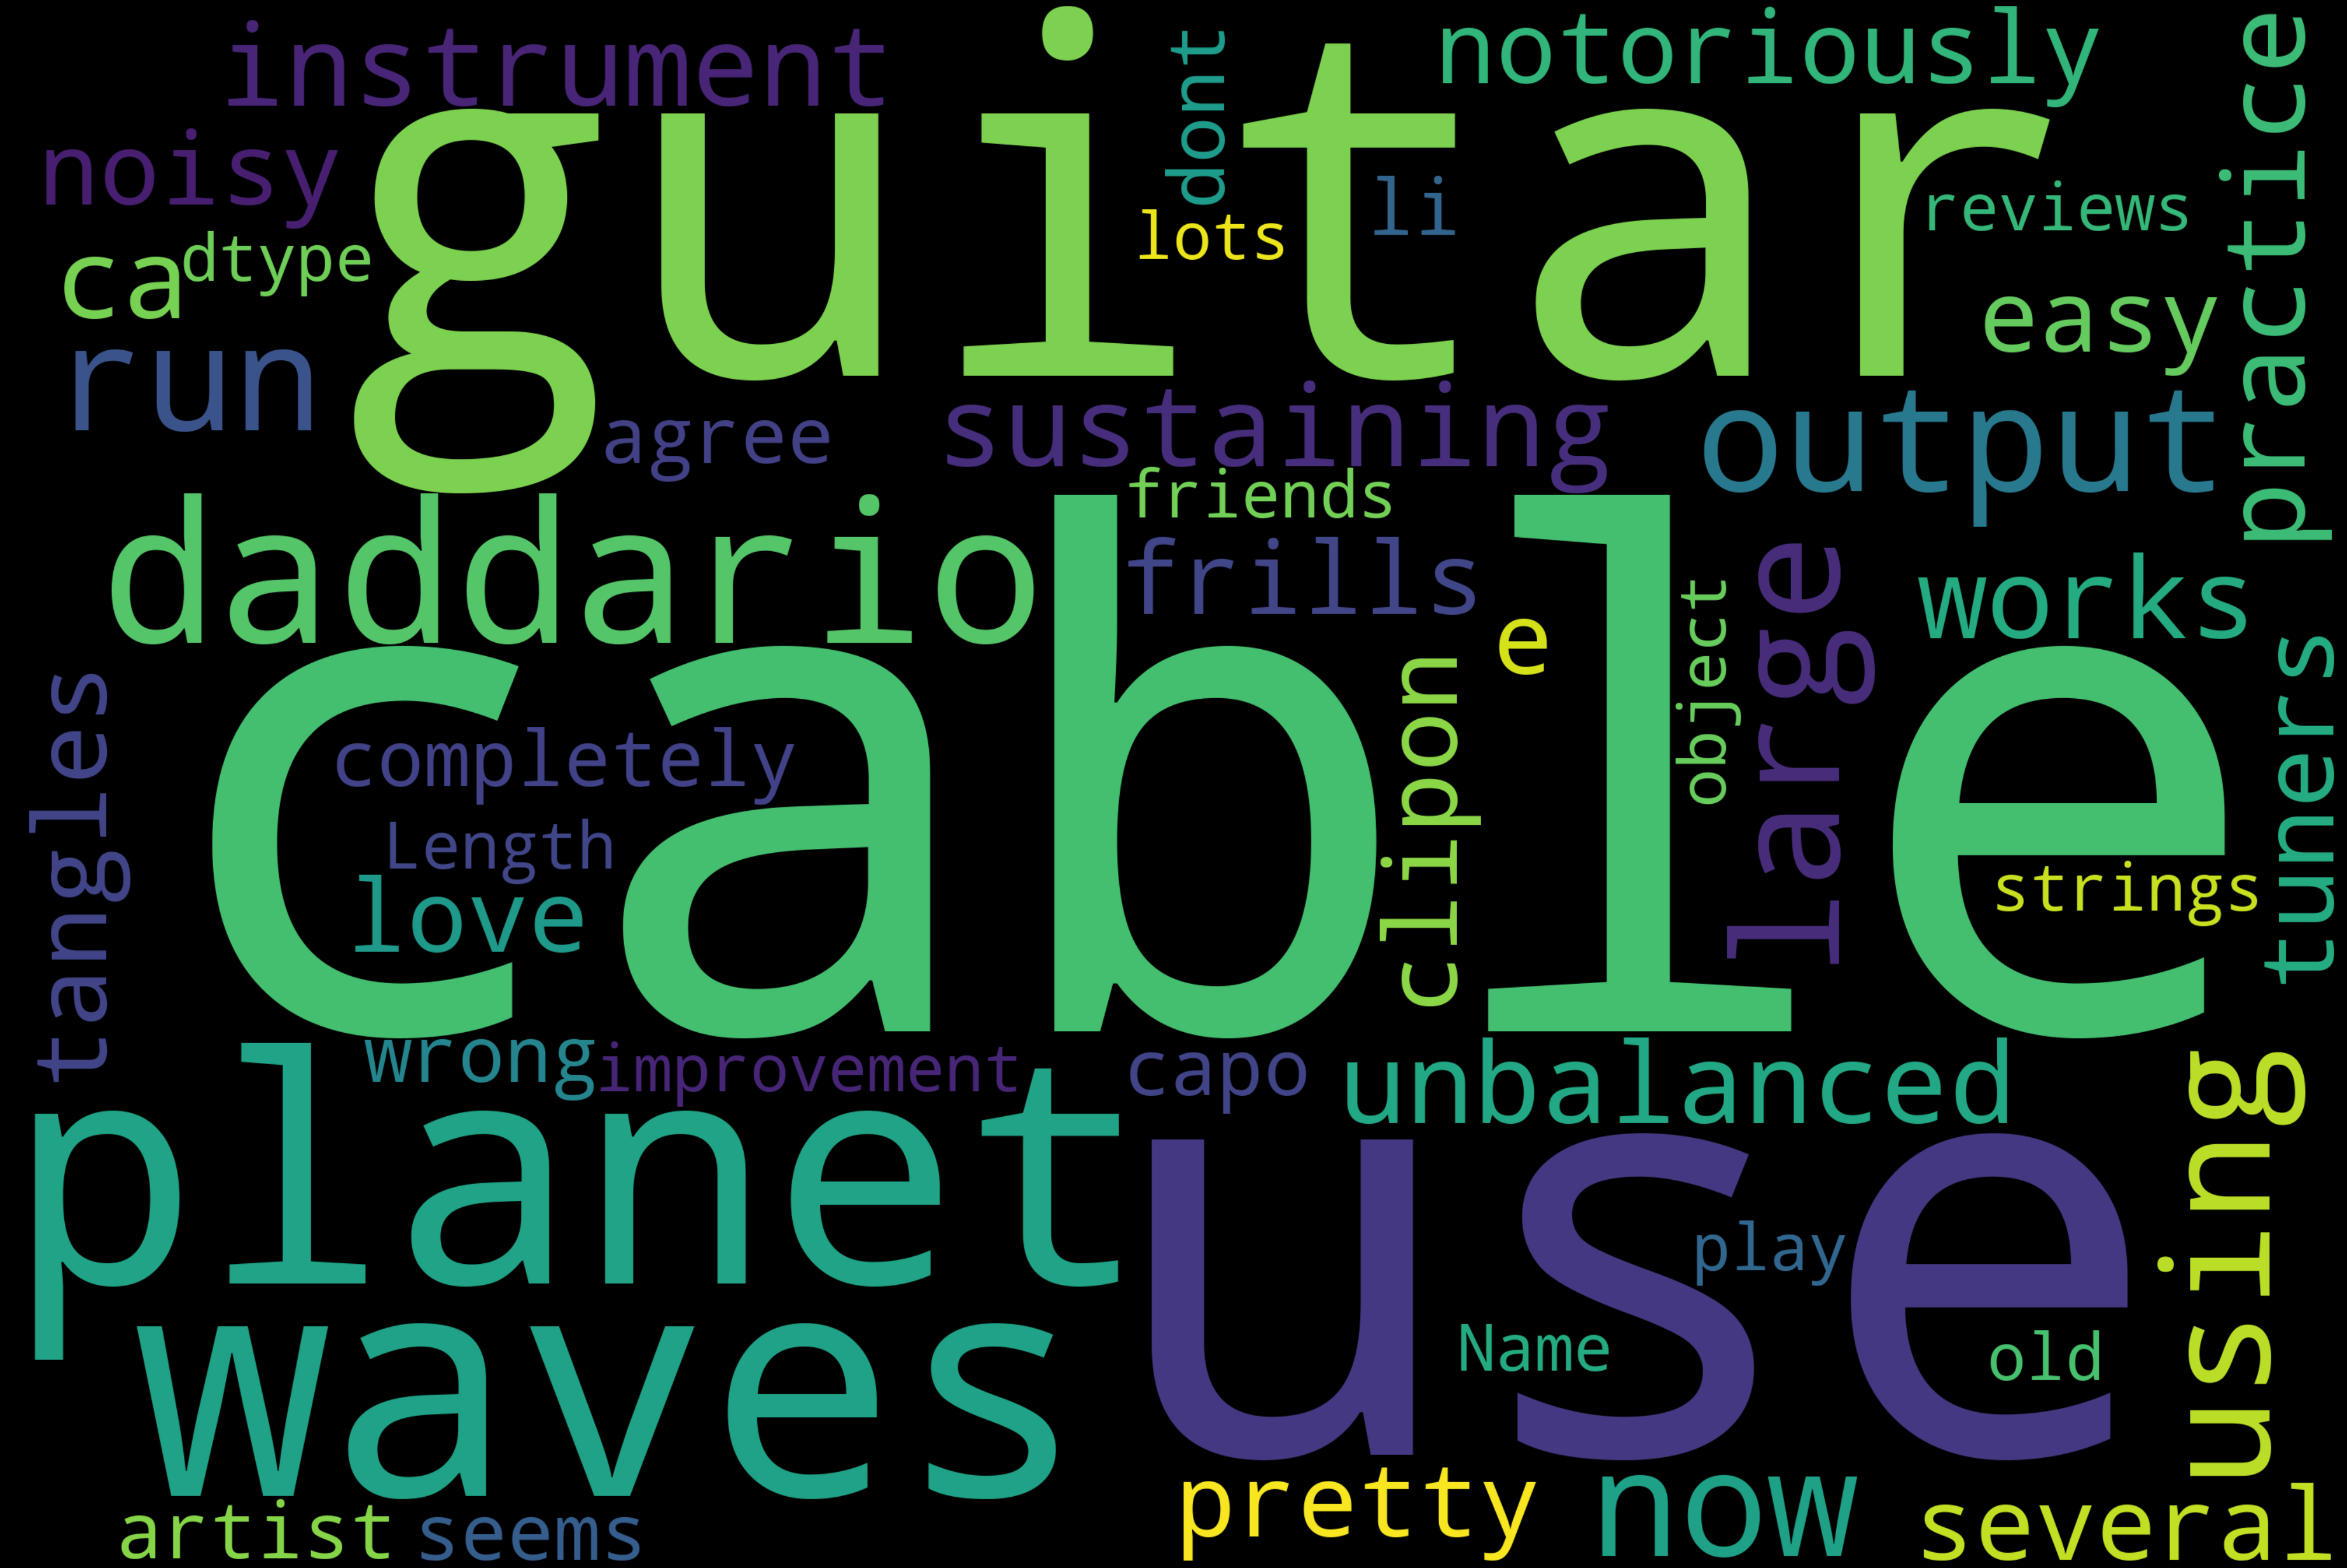

In [23]:
#Word cloud of Neutral reviews
text = review_neu["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

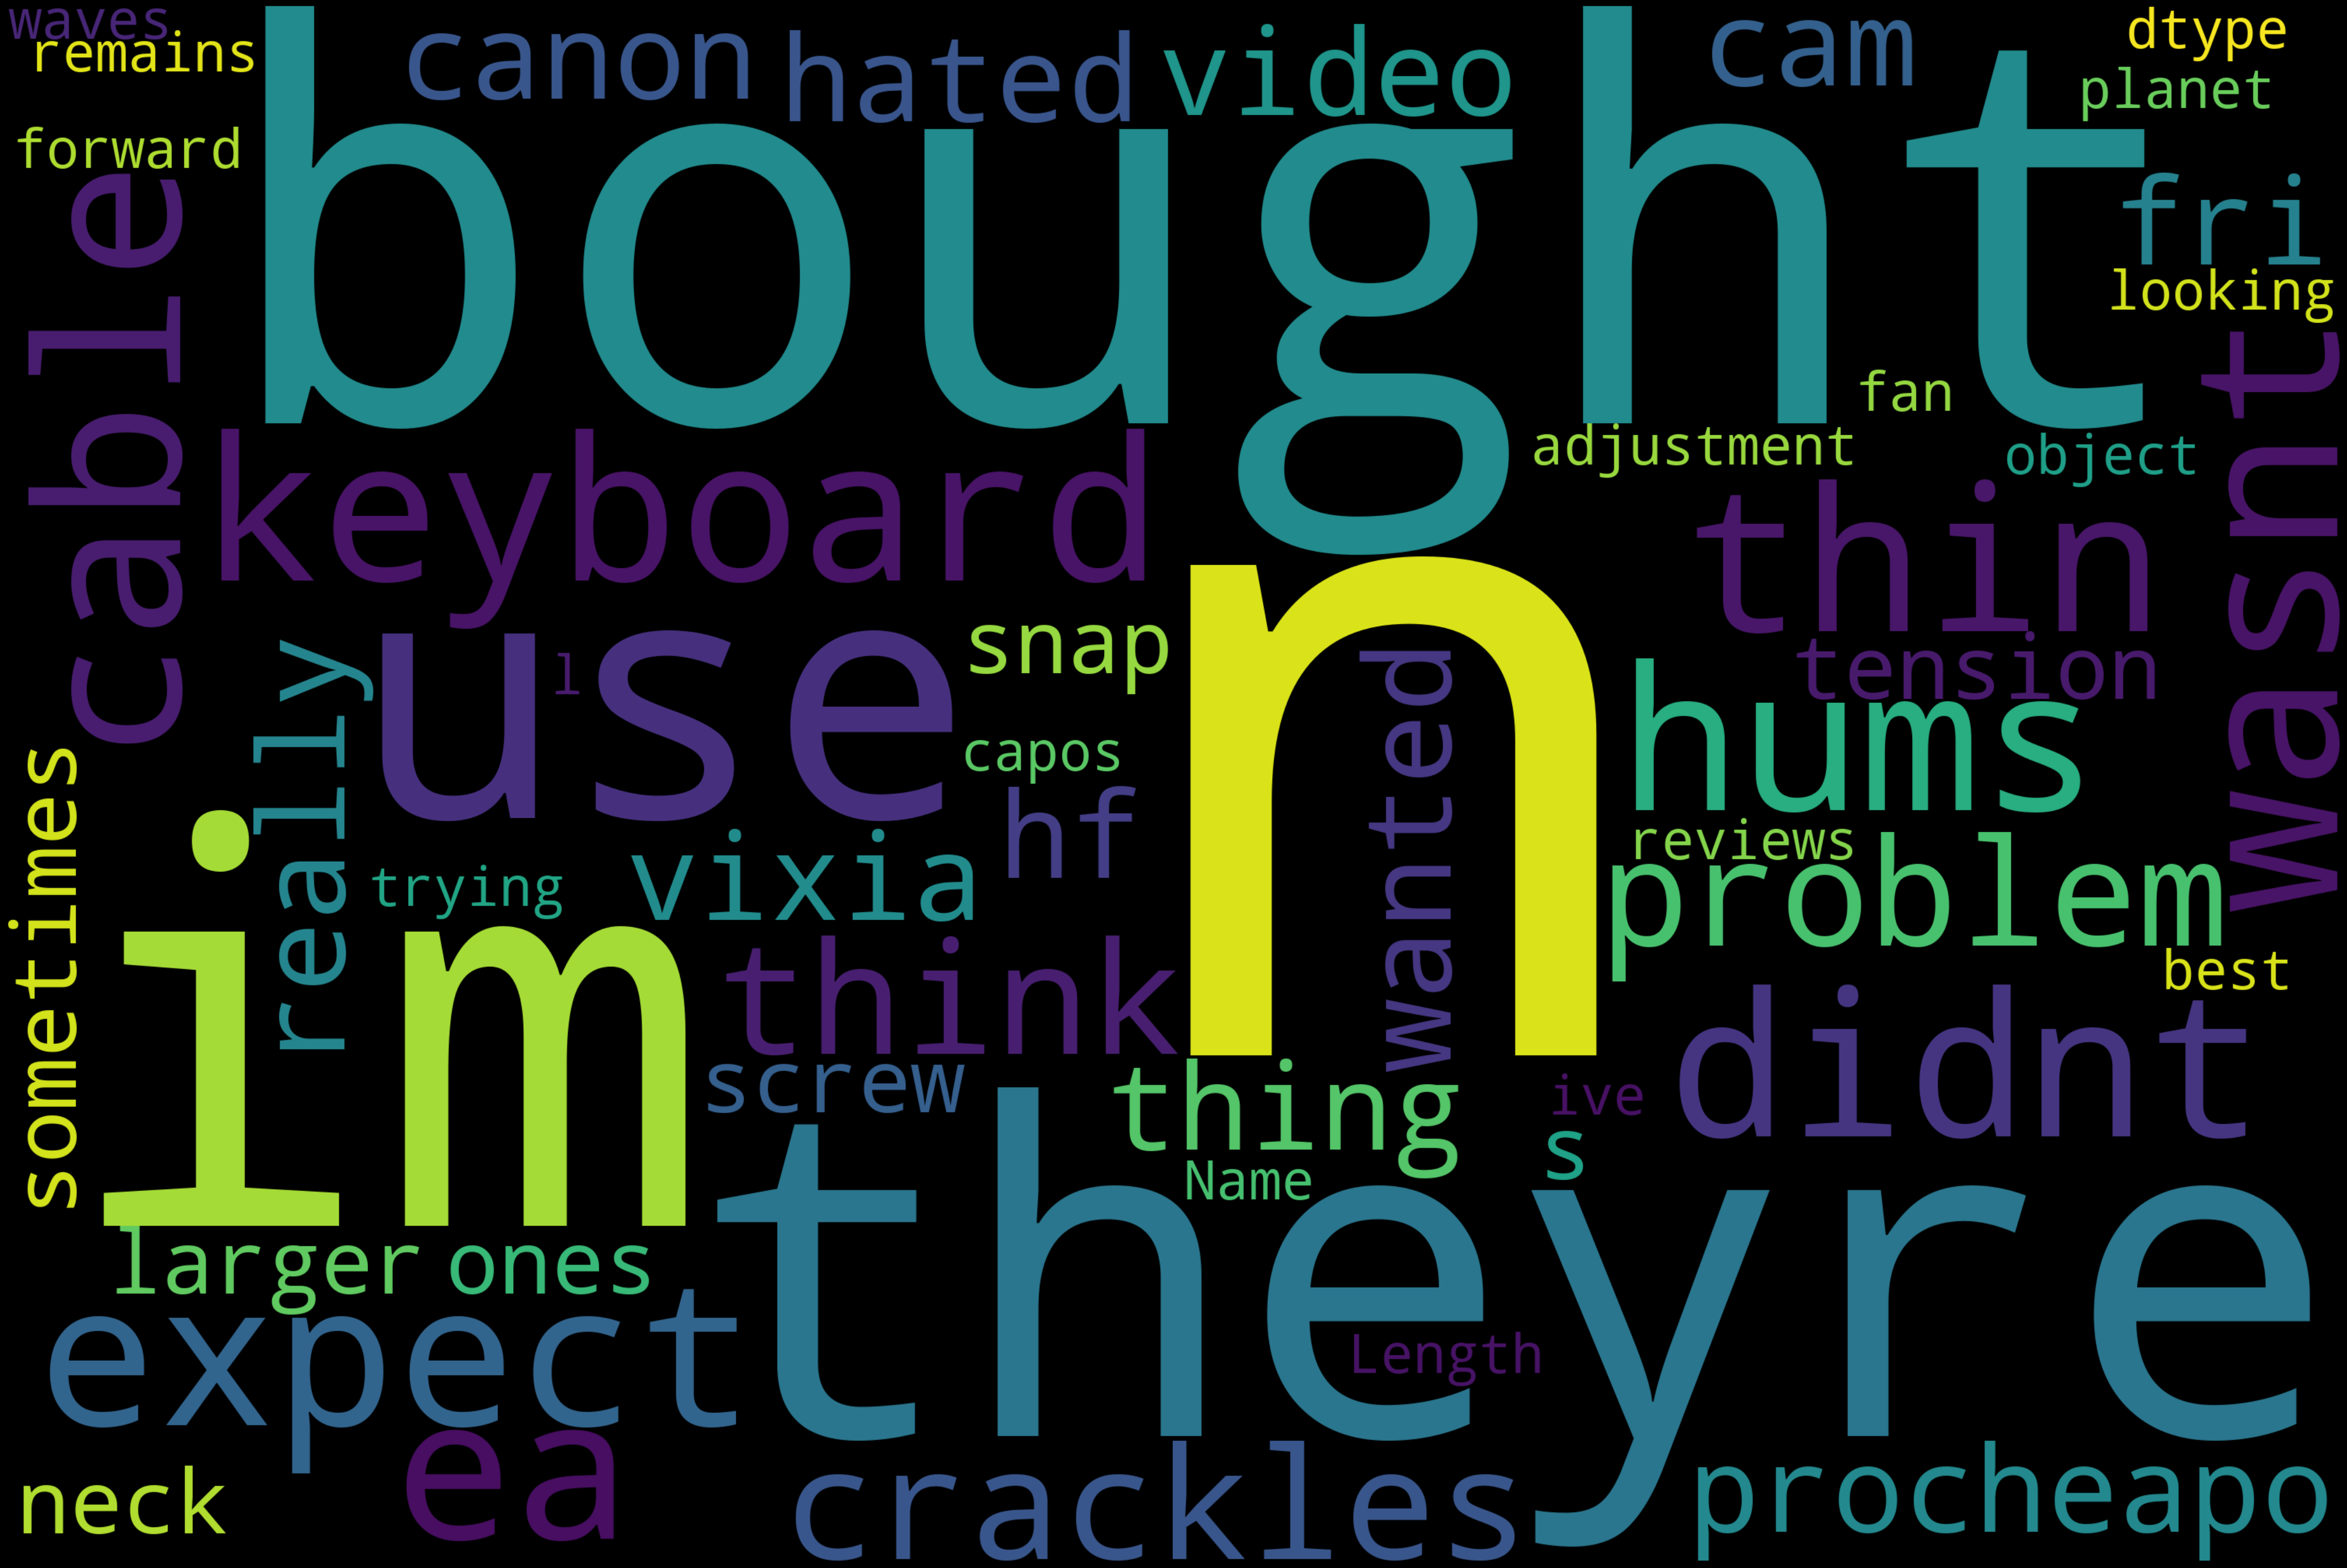

In [24]:
#world cloud of negative reviews
text = review_neg["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#Sentiment analysis with TextBlob - Polarity

In [25]:
def check_sentiment(x):
    return TextBlob(x).polarity

In [26]:
process_reviews['polarity'] = process_reviews['reviews'].apply(lambda x: check_sentiment(x))

In [27]:
process_reviews.head()

overall                                            reviews sentiment  \
0        5  not much to write about here but it does exact...  Positive   
1        5  the product does exactly as it should and is q...  Positive   
2        5  the primary job of this device is to block the...  Positive   
3        5  nice windscreen protects my mxl mic and preven...  Positive   
4        5  this pop filter is great it looks and performs...  Positive   

   polarity  
0  0.250000  
1  0.014286  
2  0.167500  
3  0.200000  
4  0.650000

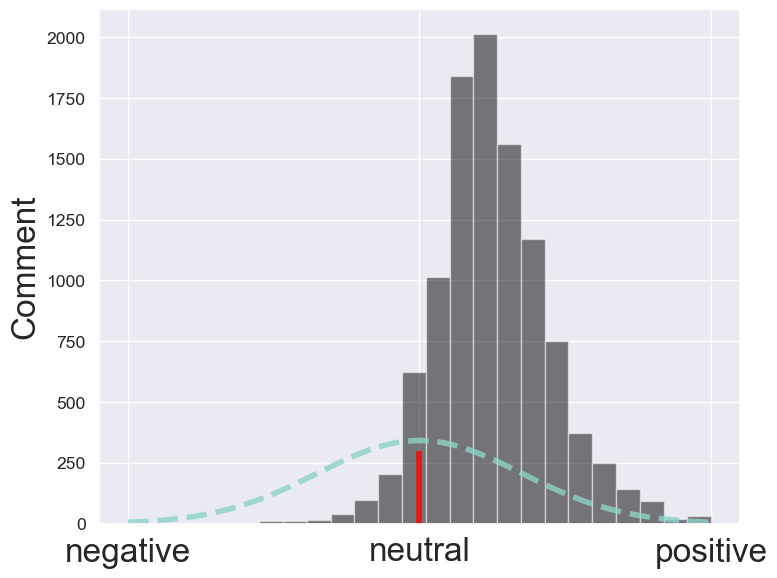

In [28]:
hist, edges = np.histogram(process_reviews.polarity.values, bins=np.arange(-2, 2, 0.1))

from scipy.stats import norm
fig, ax = plt.subplots(figsize=(8, 6))
process_reviews.polarity.hist(ax=ax, bins=20, color='k', alpha=0.5)
ax.set_xticks(range(-1, 2))
ax.set_xticklabels(['negative', 'neutral', 'positive'], fontsize=24)
ax.set_ylabel('Comment', fontsize=24)
x = np.arange(-1, 1, 0.001)
ax.plot(x, norm.pdf(x, 0, 0.35) * 300, '--', linewidth=4, alpha=0.8)
ax.vlines(0, 0, 300, color='r', linewidth=4, linestyle='-', alpha=0.8)
plt.tight_layout()
plt.show()


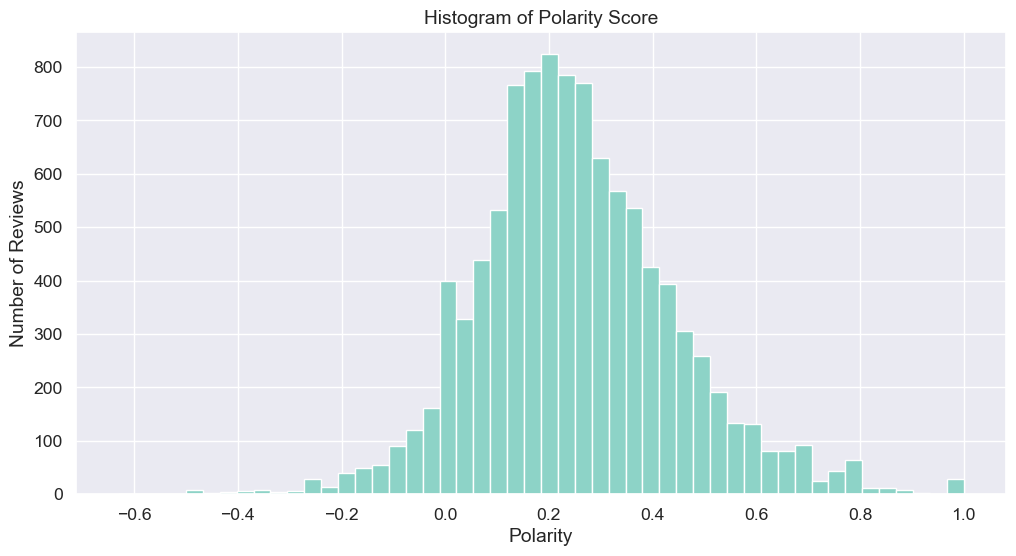

In [29]:
process_reviews['polarity'].hist(bins=50, figsize=(12,6))
plt.xlabel('Polarity')
plt.ylabel('Number of Reviews')
plt.title('Histogram of Polarity Score')
plt.show();

In [30]:
#Top 5 Reviews with highest and lowest Polarity
process_reviews.nlargest(5, ['polarity']).reviews

59      works for practice  its a guitar instrument ca...
1310                             best tool everfive stars
1700    perfect perfect size weight shape i like the m...
2007    they are some of the best drum sticks ive play...
2956                          best strings everfive stars
Name: reviews, dtype: object

In [31]:
class_names = process_reviews['sentiment'].unique()
class_names

array(['Positive', 'Neutral', 'Negative'], dtype=object)

In [32]:
process_reviews.nsmallest(5, ['polarity']).reviews

2424    the cable died on me in less than a month very...
8502    it wasnt terrible for someone who was a beginn...
1712    bought these picks for the impending strat ill...
3072    i can not evaluate the product until the instr...
4486    this was the easiest tuner i had  i am sorry i...
Name: reviews, dtype: object

In [33]:
# 2 - positive, 1- neutral, 0- negative
label_encoder = preprocessing.LabelEncoder() 

process_reviews['sentiment']= label_encoder.fit_transform(process_reviews['sentiment']) 
  
print(process_reviews['sentiment'].unique())
print(process_reviews['sentiment'].value_counts())

[2 1 0]
2    9022
1     772
0     467
Name: sentiment, dtype: int64


In [34]:
process_reviews.head()

overall                                            reviews  sentiment  \
0        5  not much to write about here but it does exact...          2   
1        5  the product does exactly as it should and is q...          2   
2        5  the primary job of this device is to block the...          2   
3        5  nice windscreen protects my mxl mic and preven...          2   
4        5  this pop filter is great it looks and performs...          2   

   polarity  
0  0.250000  
1  0.014286  
2  0.167500  
3  0.200000  
4  0.650000

In [35]:
 def generate_label(score):
  if score < 0:
    return 0
  elif score == 0:
    return 1
  else:
    return 2

In [36]:
process_reviews['Label'] = process_reviews['polarity'].apply(lambda x: generate_label(x))

In [37]:
process_reviews.head()

overall                                            reviews  sentiment  \
0        5  not much to write about here but it does exact...          2   
1        5  the product does exactly as it should and is q...          2   
2        5  the primary job of this device is to block the...          2   
3        5  nice windscreen protects my mxl mic and preven...          2   
4        5  this pop filter is great it looks and performs...          2   

   polarity  Label  
0  0.250000      2  
1  0.014286      2  
2  0.167500      2  
3  0.200000      2  
4  0.650000      2

In [38]:
accuracy_score(process_reviews['sentiment'],process_reviews['Label'])

0.8329597505116461

In [39]:
#print(confusion_matrix(process_reviews['sentiment'],process_reviews['Label']))

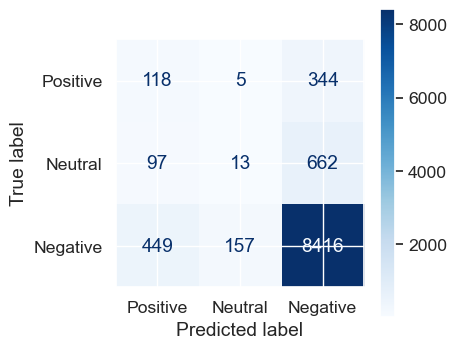

In [40]:
fig, ax = plt.subplots(figsize=(4, 4))
cmp = ConfusionMatrixDisplay.from_predictions(process_reviews['sentiment'],process_reviews['Label'],cmap=plt.cm.Blues, display_labels=class_names,ax=ax)

#Sentiment analysis with VADER 

In [41]:
sent = SentimentIntensityAnalyzer()

In [42]:
process_reviews[['neg', 'neu', 'pos', 'compound']] = process_reviews['reviews'].apply(sent.polarity_scores).apply(pd.Series)

In [43]:
process_reviews.head()

overall                                            reviews  sentiment  \
0        5  not much to write about here but it does exact...          2   
1        5  the product does exactly as it should and is q...          2   
2        5  the primary job of this device is to block the...          2   
3        5  nice windscreen protects my mxl mic and preven...          2   
4        5  this pop filter is great it looks and performs...          2   

   polarity  Label    neg    neu    pos  compound  
0  0.250000      2  0.057  0.790  0.153    0.6903  
1  0.014286      2  0.000  0.850  0.150    0.9359  
2  0.167500      2  0.106  0.842  0.052   -0.5719  
3  0.200000      2  0.050  0.769  0.181    0.5859  
4  0.650000      2  0.000  0.824  0.176    0.7650

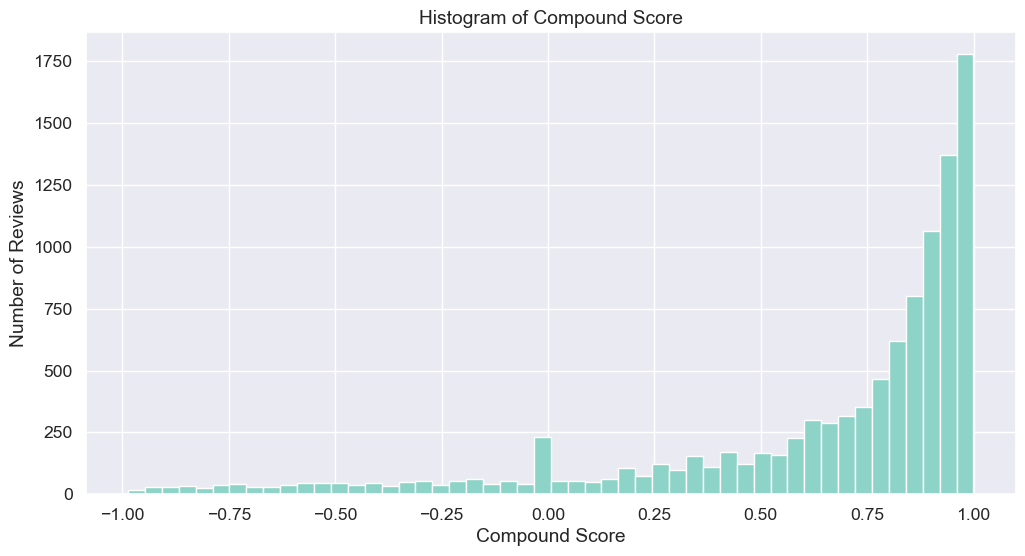

In [44]:
process_reviews['compound'].hist(bins=50, figsize=(12,6))
plt.xlabel('Compound Score')
plt.ylabel('Number of Reviews')
plt.title('Histogram of Compound Score')
plt.show();

In [45]:
process_reviews['compound_Label'] = process_reviews['compound'].apply(lambda x: generate_label(x))

In [46]:
process_reviews.head()

overall                                            reviews  sentiment  \
0        5  not much to write about here but it does exact...          2   
1        5  the product does exactly as it should and is q...          2   
2        5  the primary job of this device is to block the...          2   
3        5  nice windscreen protects my mxl mic and preven...          2   
4        5  this pop filter is great it looks and performs...          2   

   polarity  Label    neg    neu    pos  compound  compound_Label  
0  0.250000      2  0.057  0.790  0.153    0.6903               2  
1  0.014286      2  0.000  0.850  0.150    0.9359               2  
2  0.167500      2  0.106  0.842  0.052   -0.5719               0  
3  0.200000      2  0.050  0.769  0.181    0.5859               2  
4  0.650000      2  0.000  0.824  0.176    0.7650               2

In [47]:
accuracy_score(process_reviews['sentiment'],process_reviews['compound_Label'])

0.8250657830620797

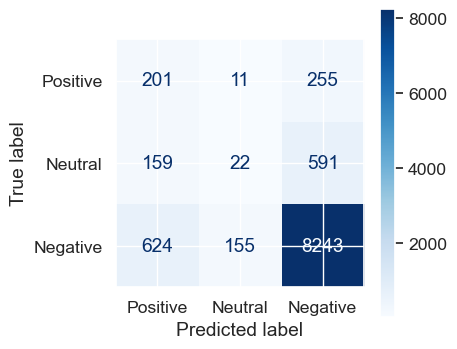

In [48]:
fig, ax = plt.subplots(figsize=(4, 4))
cmp = ConfusionMatrixDisplay.from_predictions(process_reviews['sentiment'],process_reviews['compound_Label'],cmap=plt.cm.Blues, display_labels=class_names,ax=ax)